In [70]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [71]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [72]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [73]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [74]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [75]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [76]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [77]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [78]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


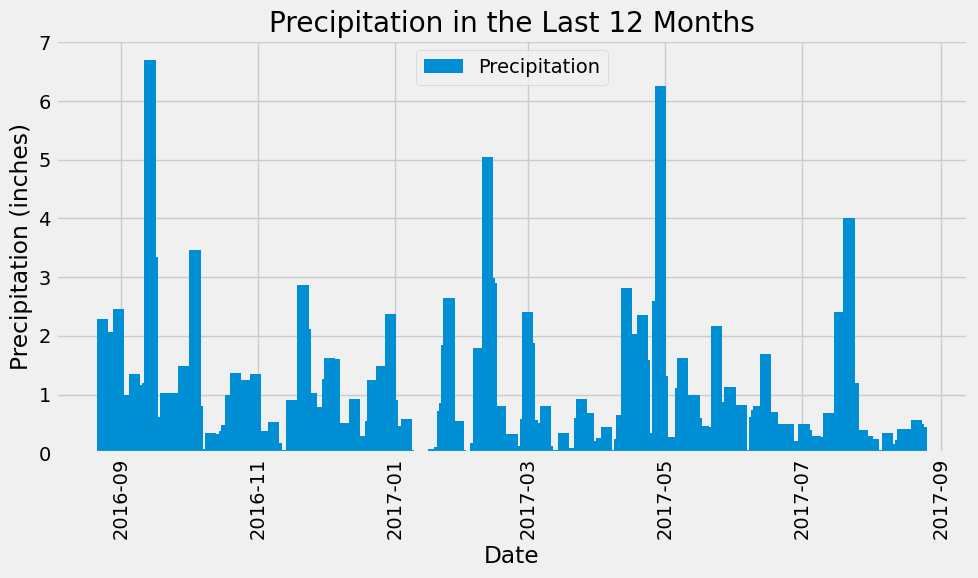

In [79]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in the dataset
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame with column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
df['Date'] = pd.to_datetime(df['Date'])  
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['Date'], df['Precipitation'], width=5, label="Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in the Last 12 Months")
plt.xticks(rotation=90)
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()

In [80]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
summary_df = pd.DataFrame(summary_statistics)
summary_df

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [81]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [82]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
# List the stations and their counts in descending order.
print("Most active stations (in descending order):")
for station, count in station_activity:
    print(f"Station: {station}, Count: {count}")

Most active stations (in descending order):
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [83]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the most active station and its ID from the previous query
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).first()

# Extract the results
lowest_temperature = temperature_data[0]
highest_temperature = temperature_data[1]
average_temperature = temperature_data[2]

# Print the results
print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {lowest_temperature}")
print(f"Highest Temperature: {highest_temperature}")
print(f"Average Temperature: {average_temperature}")

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


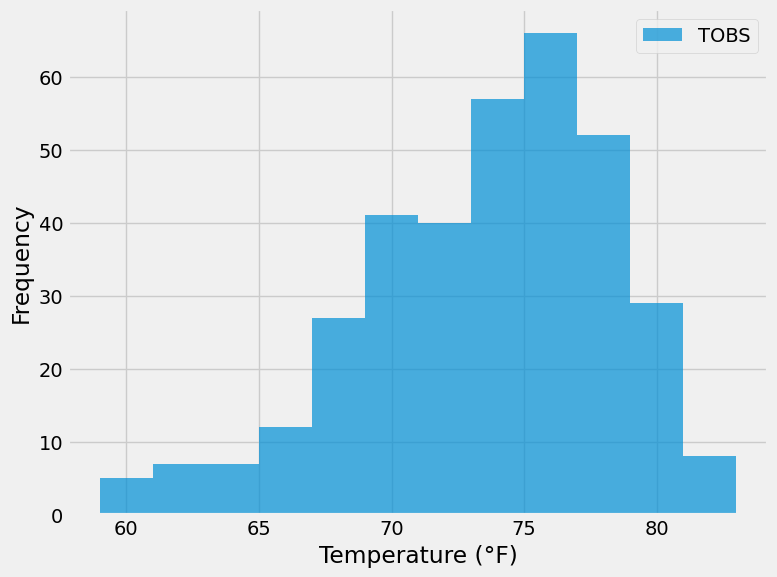

In [84]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the most recent date in the database
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Query temperature observations for the most active station in the last 12 months
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Extract temperature values
temperatures = [temp[0] for temp in temperature_data]

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, label="TOBS", alpha=0.7)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [85]:
# Close Session
session.close()